# Exploratory Data Analysis - Lyrics

In [1]:
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
import numpy as np
from sklearn.decomposition import PCA, LatentDirichletAllocation
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import json
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import RidgeCV, LogisticRegressionCV

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [2]:
with open('../data/top_hits_merged_clean_lyrics_audio_features.json') as json_file:
    top_hits_lyrics_json = json.load(json_file)
    
with open('../data/not_hits_merged_clean_lyrics_audio_features.json') as json_file:
    not_hits_lyrics_json = json.load(json_file)

In [3]:
top_hits_lyrics_df = pd.read_json(top_hits_lyrics_json)
not_hits_lyrics_df = pd.read_json(not_hits_lyrics_json)

In [4]:
df = pd.concat([top_hits_lyrics_df, not_hits_lyrics_df])

In [5]:
# when creating word clouds, maps word fontsize to a color
class colormap_size_func(object):
    def __init__(self, colormap, max_font_size):
        import matplotlib.pyplot as plt
        self.colormap = plt.cm.get_cmap(colormap)
        self.max_font_size = max_font_size

    def __call__(self, word, font_size, position, orientation,
                 random_state=None, **kwargs):
        if random_state is None:
            random_state = Random()
        r, g, b, _ = 255 * np.array(self.colormap(font_size / self.max_font_size))
        return "rgb({:.0f}, {:.0f}, {:.0f})".format(r, g, b)

# Most decade specific words

In the word clouds below, we can see the most specific 1-grams and 2-grams in each decade. 

We can notice the difference between 1970s, where most specific words are letter, thrill, smiling, and the 2010s, where the most specific words are club, pop, sexy, ladies. 

In [6]:
lyrics = df['clean_lyrics']
sns.set(context='poster', style='white')

def ngram_wordclouds(n=1, min_df=50):
    # make features and targets
    X = lyrics.copy()
    y = df['decade']
    
    # make and fit Naive Bayes model
    stop_words = list(ENGLISH_STOP_WORDS)
    stop_words.extend(['shes', 'yes', 'didnt'])
    pipe = Pipeline([('count', CountVectorizer(min_df=min_df, binary=True,
                                    ngram_range=(n,n), stop_words=stop_words)),
                     ('bnb', BernoulliNB(binarize=0))])
    pipe.fit(X, y)

    # calculate class conditional feature probabilities and ...
    # unconditioned feature probabilities.
    feature_counts = pipe.named_steps.count.transform(lyrics).toarray().sum(axis=0)
    class_feature_counts = pipe.named_steps.bnb.feature_count_
    con_feat_probs = class_feature_counts / class_feature_counts.sum(axis=1).reshape(-1, 1)
    unc_feat_probs = feature_counts / feature_counts.sum()
    
    # conditional probability / unconditional probability = lift
    lift = con_feat_probs / unc_feat_probs + 1e-10
    
    # make subplot axes
    fig, axes = plt.subplots(1, 5, figsize=(18,10))
    axes = axes.ravel()

    colormaps = ['Purples', 'Blues', 'Greens', 'Oranges', 'Reds']
    vocab = pipe.named_steps.count.get_feature_names()
    for i, decade in enumerate(range(1970, 2020, 10)):
        # make word-weight dictionary
        color_func = colormap_size_func(colormaps[i], 300)
        feature = lift[i,:]
        dictionary = dict(zip(vocab, feature))
        
        # make word cloud
        wordcloud = WordCloud(background_color='white', height=1200,
                              min_font_size=5, width=1400, color_func=color_func,
                              max_words=200, relative_scaling=0.5,
                              max_font_size=300)
        wordcloud = wordcloud.generate_from_frequencies(dictionary)
        
        # display word cloud
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].axis('off')
        axes[i].set(title='Most {}s {}-grams'.format(decade, n))
        
plt.rc('axes', titlesize=14)

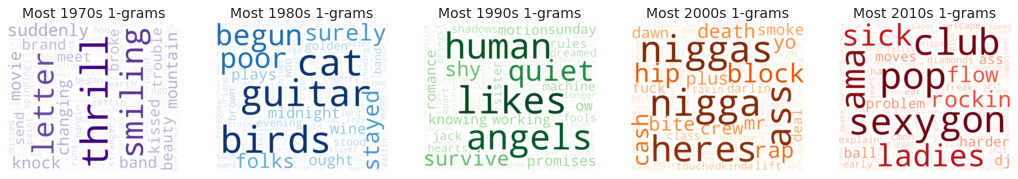

In [7]:
ngram_wordclouds()

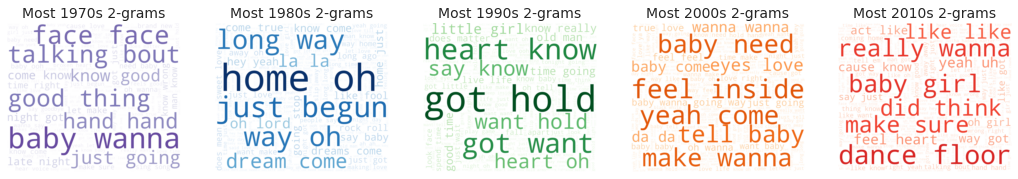

In [8]:
ngram_wordclouds(2, 30)

# Topic Modeling

Topic modeling is a method of discovering what types of topics exist within the corpus of lyrics. Latent Dirichlet Allocation (LDA) is a particularly powerful technique that models topics as a distribution over words and songs as a distribution over topics. In modeling the lyrics, we found 9 topics. The word clouds below show the most probable words to appear in each topic.

In the first word cloud we can see words such as dance, forever, dancing, body, free, boogie. So, the topic of these songs could be party songs. 

In the second word cloud we can see words such as sweet, dream, girl, loves, lady, lonely, magic. The topic of these songs could be nostalgic songs.

In the fourth word cloud we can see words such as walk, run, bad, somebody, rain, tears, hurt, pain. The topic of these songs could be sad/lonely songs.

In the last word cloud we can see words such as money, shit, fuck, crazy. The topic of these songs could be explicit songs.

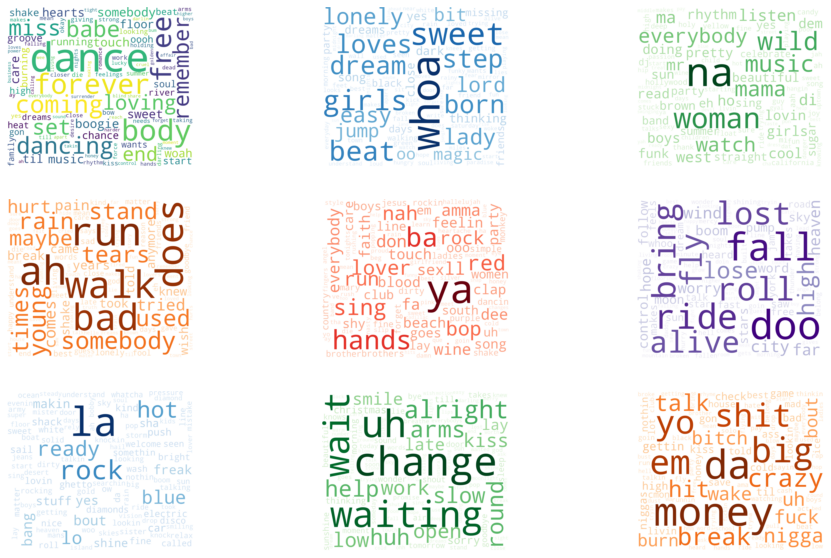

In [9]:
clean_lyrics = df['clean_lyrics'].to_numpy()
count = CountVectorizer(stop_words='english', min_df=10, max_df=500)
X_vect = count.fit_transform(np.array(clean_lyrics))

# perform LDA and get the indices of top n_words_display words of each topic
n_topics = 9
n_words_display = 100
lda = LatentDirichletAllocation(n_components=n_topics)
X_lda = lda.fit_transform(X_vect)
indices = (-lda.components_).argsort(axis=1)[:,:n_words_display]
vocab = np.array(count.get_feature_names())
# cmaps = ['YlOrBr', 'cool', 'bone_r', 'winter_r', 'spring_r', 'YlOrBr', 'cool', 'bone_r', 'winter_r']
cmaps = ['Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'Purples', 'Blues', 'Greens', 'Oranges']

# generate subplot axes
fig, axes = plt.subplots(3, 3, figsize=(16,10))
axes = axes.ravel()

for i in range(n_topics):
    if i == 0:
        color_func = None
    else:
        color_func = colormap_size_func(cmaps[i], 300)
    weights = lda.components_[i][indices[i]]
    words = vocab[indices[i,:]]
    dictionary = dict(zip(words, weights))
    wordcloud = WordCloud(background_color='white', height=1200, min_font_size=5,
                      width=1400, color_func=color_func,
                      max_words=n_words_display, relative_scaling=0.5,
                      max_font_size=300)
    wordcloud = wordcloud.generate_from_frequencies(dictionary)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')